In [24]:
import pandas as pd
data = pd.read_csv("DS_BTS_SAL_EQTP_SEX_PCS_2023_data.csv", sep=";")
metadata = pd.read_csv("DS_BTS_SAL_EQTP_SEX_PCS_2023_metadata.csv", sep=";") #Définition des variables
data.columns

Index(['GEO', 'GEO_OBJECT', 'FREQ', 'SEX', 'PCS_ESE', 'DERA_MEASURE',
       'CONF_STATUS', 'TIME_PERIOD', 'OBS_VALUE'],
      dtype='object')

Rajouter ici les variables et leurs définitions :



*   CONF_STATUS = Statut de confidentialité (F = Diffusable / C = Confidentiel)
*   DERA_MEASURE = Salaire Net mensuel moyen en équivalent temps plein
*   FREQ = Fréquence (A = annuel)
*   PCS_ESE = Profession et cat. socio pro

3.  = (1T3)Cadres y compris chefs d'entreprise
4.  = Professions intermédiaires
5.  = Employés
6.  = Ouvriers


*   SEX = Sexe (F, M et _T pour tous sexes confondus)
*   GEO = Codes villes
*   GEO_OBJECT = Autre code géo, peut être région ou dpt?
*   TIME_PERIOD = 2022 / 2023
*   OBS_VALUE = Salaire





















In [25]:
#TO DO NETTOYAGE
#Vérif les doublons
#Vérif les valeurs manquantes
#Outliers
#Transformer les variables qualitatives en variables quanti pour machine learning
#Transformer 1T3 en 3

In [26]:
#Doublons
print(data.duplicated().sum())
#Pas de doublons

0


In [27]:
#Nombre de valeurs manquantes par colonne
print(data.isna().sum())

GEO                 0
GEO_OBJECT          0
FREQ                0
SEX                 0
PCS_ESE             0
DERA_MEASURE        0
CONF_STATUS         0
TIME_PERIOD         0
OBS_VALUE       20460
dtype: int64


In [28]:
# Lignes avec OBS_VALUE manquant
missing_values = data[data['OBS_VALUE'].isna()]

#Les NaN correspondent aux valeurs en confidentiel, donc il faut supprimer les lignes correspondantes


In [29]:
#Suppression des lignes où le salaire est condifentiel donc pas utile
data = data[data["CONF_STATUS"] != "C"]

In [30]:
#Suppression des valeurs _T (total)
data = data[(data["PCS_ESE"] != "_T") & (data["SEX"] != "_T")]

In [31]:
#Vérif que les valeurs _T ont bien été supprimées dans les colonnes SEX & PCS_ESE

print(data["PCS_ESE"].unique())
print(data["SEX"].unique())

['4' '5' '6' '1T3']
['F' 'M']


In [32]:
#Transformer 1t3 en 3 (catégorie socio pro)
data["PCS_ESE"] = data["PCS_ESE"].replace("1T3", "3")
print(data ["PCS_ESE"].unique())

['4' '5' '6' '3']


In [33]:
#Supprimer la colonne DERA_MEASURE qui contient toujours la meme valeur
data.drop(columns=["DERA_MEASURE"], inplace=True)

#Même chose pour la fréquence qui est toujours annuelle
data.drop(columns=["FREQ"], inplace=True)

In [34]:
#Supprimer la colonne CONF_STATUS qui n'a plus de sens maintenant que l'on a supprimé les lignes C
data = data.drop(columns=["CONF_STATUS"])

In [35]:
print(data.columns)

Index(['GEO', 'GEO_OBJECT', 'SEX', 'PCS_ESE', 'TIME_PERIOD', 'OBS_VALUE'], dtype='object')


In [36]:
data = data.rename(columns={"OBS_VALUE": "WAGE"})
data = data.rename(columns={"PCS_ESE": "PCS"})
data = data.rename(columns={"TIME_PERIOD": "YEAR"})
data = data.rename(columns={"GEO_OBJECT": "INSEE ZONING"})
data = data.rename(columns={"GEO": "CITY"})


In [37]:
#Arrondir les salaires à deux décimales, car ce sont déjà des moyennes annuelles
data["WAGE"] = data["WAGE"].round(2)

print(data["WAGE"].unique())

[2107.22 2303.18 1844.06 ... 2382.16 2017.75 2774.94]


In [38]:
print(data.columns)

Index(['CITY', 'INSEE ZONING', 'SEX', 'PCS', 'YEAR', 'WAGE'], dtype='object')


#Idées TO DO analyse

1.   Ecart Salaire H/F
2.   Salaire par région
3.   Evolution salariale dans le temps (22/23)
4.   Salaire par cat. socio pro




Ecart Salaire



In [39]:
import pandas as pd

#Calcul de l'écart salarial H/F
moyennes = data[data["SEX"].isin(["F", "M"])].groupby("SEX")["WAGE"].mean()

ecart_valeur = moyennes["M"] - moyennes["F"]
ecart_pourcentage = (ecart_valeur / moyennes["F"]) * 100

print(f"Écart salarial H/F : {ecart_valeur:.2f} €")
print(f"Écart en pourcentage : {ecart_pourcentage:.2f} %")

Écart salarial H/F : 310.96 €
Écart en pourcentage : 13.39 %


In [40]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 186800 entries, 4 to 370705
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CITY          186800 non-null  object 
 1   INSEE ZONING  186800 non-null  object 
 2   SEX           186800 non-null  object 
 3   PCS           186800 non-null  object 
 4   YEAR          186800 non-null  int64  
 5   WAGE          186800 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.0+ MB


,YEAR,WAGE
count,186800.000000,186800.000000
mean,2022.500000,2477.405105
std,0.500001,825.895117
min,2022.000000,793.400000
25%,2022.000000,1860.790000
50%,2022.500000,2173.025000
75%,2023.000000,2891.312500
max,2023.000000,14047.320000


In [41]:

import plotly.graph_objects as go

# effet miroir pour le violon lol
fig = go.Figure() #

# Hommes (côté gauche)
fig.add_trace(go.Violin(
    y=data[data["SEX"] == "M"]["WAGE"],
    x=["Sexe"] * len(data[data["SEX"] == "M"]),
    name="Homme",
    side="negative",
    line_color="#1E90FF",
    fillcolor="rgba(30,144,255,0.6)",
    box_visible=True,
    meanline_visible=True,
    points=False  # pas de points
))

# Femmes (côté droit)
fig.add_trace(go.Violin(
    y=data[data["SEX"] == "F"]["WAGE"],
    x=["Sexe"] * len(data[data["SEX"] == "F"]),
    name="Femme",
    side="positive",
    line_color="#FF69B4",
    fillcolor="rgba(255,105,180,0.6)",
    box_visible=True,
    meanline_visible=True,
    points=False  # pas de points
))

# Mise en page
fig.update_layout(
    title="Distribution des salaires par sexe (violon miroir)",
    yaxis_title="Salaire (€)",
    xaxis_title="Sexe",
    violingap=0,
    violinmode="overlay",
    legend_title="Sexe"
)

fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# Pour les femmes
print("Femmes")
print(data[data["SEX"] == "F"]["WAGE"].describe())

# Pour les hommes
print("\nHommes")
print(data[data["SEX"] == "M"]["WAGE"].describe())

Femmes
count    93400.000000
mean      2321.923518
std        710.374788
min        793.400000
25%       1787.720000
50%       2069.580000
75%       2676.055000
max       7859.410000
Name: WAGE, dtype: float64

Hommes
count    93400.000000
mean      2632.886691
std        900.683567
min       1040.130000
25%       1947.297500
50%       2301.445000
75%       3029.355000
max      14047.320000
Name: WAGE, dtype: float64


In [ ]:

import plotly.express as px

# Filtr les sexes valides et les valeurs non nulles
df_sexe = data[data["SEX"].isin(["F", "M"])].dropna(subset=["WAGE"])

# Calcul des moyennes
salaire_moyen = df_sexe.groupby("SEX")["WAGE"].mean().reset_index()

# Graphique interactif
fig = px.bar(
    salaire_moyen,
    x="SEX",
    y="WAGE",
    color="SEX",
    text="WAGE",
    title="Salaire moyen par sexe",
    labels={"WAGE": "Salaire (€)", "SEX": "Sexe"},
    color_discrete_map={"F": "#FF69B4", "M": "#1E90FF"}
)


fig.update_traces(texttemplate='%{text:.2f} €', textposition='outside')
fig.update_layout(yaxis=dict(title="Salaire moyen (€)"), xaxis=dict(title="Sexe"))
fig.show()



Evolution salariale dans le temps (22/23)

In [ ]:

# Filtrer les salaires et années valides
df_year = data[data["WAGE"].notna() & data["YEAR"].notna()]

# Calcul de la médiane par année
mediane_par_annee = df_year.groupby("YEAR")["WAGE"].median().reset_index()
mediane_par_annee.columns = ["Année", "Médiane salaire (€)"]

# Graphique interactif
fig = px.bar(
    mediane_par_annee.sort_values("Année"),
    x="Année",
    y="Médiane salaire (€)",
    text="Médiane salaire (€)",
    title="Médiane des salaires par année",
    labels={"Année": "Année", "Médiane salaire (€)": "Salaire médian (€)"},
    color="Médiane salaire (€)",
    color_continuous_scale="Blues"
)

fig.update_traces(texttemplate='%{text:.2f} €', textposition='outside')
fig.update_layout(xaxis=dict(type='category'))
fig.show()

In [ ]:
# Calcul de la médiane salariale par année
evol_series = (
    data.groupby("YEAR")["WAGE"]
        .median()
        .sort_index()
)

# Tableau récapitulatif
evol_df = evol_series.round(2).to_frame("salaire_médian")
print(evol_df)

# Calcul écart 2022 → 2023
if 2022 in evol_series.index and 2023 in evol_series.index:
    v22 = float(evol_series.loc[2022])
    v23 = float(evol_series.loc[2023])
    diff = v23 - v22
    pct = (diff / v22) * 100 if v22 != 0 else float("nan")
    print(f" Évolution médiane 2022→2023 : {diff:.2f} €  ({pct:.2f} %)")
else:
    print(" Années 2022 et/ou 2023 absentes des données.")

      salaire_médian
YEAR                
2022         2129.72
2023         2215.64
 Évolution médiane 2022→2023 : 85.91 €  (4.03 %)


In [ ]:
# Filtrer les données valides
df_valid = data[data["WAGE"].notna() & data["CITY"].notna() & data["PCS"].notna()]

# Calcul des médianes par ville et PCS
mediane_ville_pcs = (
    df_valid.groupby(["CITY", "PCS"])["WAGE"]
    .median()
    .reset_index()
    .round(2)
)

# Affichage
print("\n Médiane des salaires par ville et PCS :")
print(mediane_ville_pcs.sort_values(by="WAGE", ascending=False))


 Médiane des salaires par ville et PCS :
        CITY PCS     WAGE
26292  62270   3  7613.68
31100  75107   3  6759.74
32340  77441   3  6670.60
31868  77101   3  6670.60
37064  94037   3  6652.72
...      ...  ..      ...
3803   14104   6  1029.59
2951   11279   6  1028.12
2831   11105   6  1028.12
3971   14229   6  1022.54
22683  54318   6   998.83

[38252 rows x 3 columns]


Salaire par catégorie socio-professionnelle

In [ ]:
# Salaire par catégorie socio-professionnelle
pcs_stats = (
    data.groupby("PCS")["WAGE"]
        .agg(moyenne="mean", mediane="median", n="size")
        .sort_values("moyenne", ascending=False)
        .round(2)
)

print(pcs_stats)

# Écart entre la PCS la mieux rémunérée et la moins rémunérée
if len(pcs_stats) >= 2:
    top = pcs_stats["moyenne"].iloc[0]
    low = pcs_stats["moyenne"].iloc[-1]
    ecart = top - low
    print(f"Écart Top − Bottom PCS : {ecart:.2f} €")


     moyenne  mediane      n
PCS                         
3    3683.01  3608.06  46700
4    2468.10  2427.34  46700
6    1882.10  1880.32  46700
5    1876.41  1852.36  46700
Écart Top − Bottom PCS : 1806.60 €


Salaire moyen par PCS et par ville

In [ ]:
# Salaire moyen par PCS et par ville
pcs_ville = (
    data.groupby(["CITY", "PCS"])["WAGE"]
        .mean()
        .reset_index()
        .round(2)
        .sort_values(by=["CITY", "WAGE"], ascending=[True, False])
)

print(pcs_ville.head(20))  # affiche les 20 premières lignes


     CITY PCS     WAGE
0     001   3  5120.56
1     001   4  2839.87
2     001   5  2045.07
3     001   6  1911.92
4   00152   3  2743.33
5   00152   4  2317.09
6   00152   5  1836.74
7   00152   6  1831.50
8   00154   3  3556.35
9   00154   4  2556.26
11  00154   6  1977.45
10  00154   5  1748.20
12  00156   3  3715.19
13  00156   4  2296.37
15  00156   6  1857.17
14  00156   5  1814.23
16  00158   3  3960.46
17  00158   4  2511.16
19  00158   6  2026.72
18  00158   5  1822.96


analyser une ville spécifique

A) Normaliser le code ville et calculer PCS × ville

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Code ville normalisé sur 5 chiffres (style code INSEE)
data["CITY_CODE"] = (
    data["CITY"].astype(str)
        .str.extract(r"(\d+)", expand=False)   # garde les chiffres
        .fillna(data["CITY"].astype(str))      # si pas de chiffres, garde tel quel
        .str.zfill(5)                          # zero-padding à gauche
)

# (option) Filtrer une année
# data = data[data["YEAR"] == 2023]

# 2) Salaire moyen par ville × PCS
pcs_city = (
    data.groupby(["CITY_CODE", "PCS"])["WAGE"]
        .mean()
        .reset_index()
        .round(2)
)

print(pcs_city.head(15))


   CITY_CODE PCS     WAGE
0      00001   3  4480.64
1      00001   4  2695.89
2      00001   5  1977.31
3      00001   6  1887.28
4      00002   3  3330.35
5      00002   4  2463.91
6      00002   5  1884.41
7      00002   6  1844.91
8      00003   3  4020.13
9      00003   4  2626.38
10     00003   5  1893.77
11     00003   6  1874.41
12     00004   3  3832.34
13     00004   4  2468.09
14     00004   5  1861.08


Top 10 villes (codes) où une PCS donnée est la mieux payée

In [ ]:
TARGET_PCS = "3"  # change selon ta PCS (ex: "3", "4", "5", "6")
top10 = (pcs_city[pcs_city["PCS"] == TARGET_PCS]
         .sort_values("WAGE", ascending=False)
         .head(10))
print(top10)


      CITY_CODE PCS     WAGE
26408     62270   3  7364.80
30804     75107   3  6922.01
36064     94037   3  6684.50
31360     77101   3  6628.93
31820     77441   3  6628.93
30808     75108   3  6462.84
35984     93073   3  6368.51
30780     75101   3  6290.76
21452     45273   3  6281.40
16696     33099   3  6205.11


Comparer toutes les PCS pour une ville (par code) :

    CITY_CODE PCS     WAGE
616     00154   3  3558.46
617     00154   4  2447.22
619     00154   6  1900.39
618     00154   5  1787.52


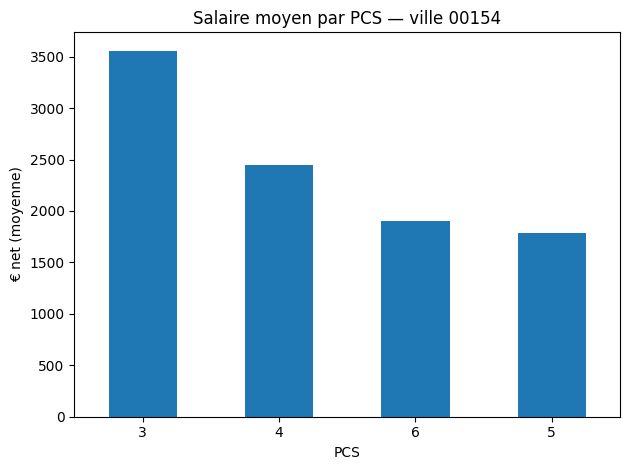

In [ ]:
CITY_CHOICE = "00154"  # mets ici un code vu dans tes données
subset = (pcs_city[pcs_city["CITY_CODE"] == CITY_CHOICE]
          .sort_values("WAGE", ascending=False))
print(subset)

# Graphique si non vide
if not subset.empty:
    ax = subset.plot(kind="bar", x="PCS", y="WAGE", legend=False)
    ax.set_title(f"Salaire moyen par PCS — ville {CITY_CHOICE}")
    ax.set_ylabel("€ net (moyenne)")
    ax.set_xlabel("PCS")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


Tableau comparatif large (lignes = villes, colonnes = PCS) :

In [ ]:
pivot = pcs_city.pivot(index="CITY_CODE", columns="PCS", values="WAGE")
print(pivot.head())
# Export si besoin
# pivot.to_csv("salaires_pcs_par_ville_code.csv")


PCS              3        4        5        6
CITY_CODE                                    
00001      4480.64  2695.89  1977.31  1887.28
00002      3330.35  2463.91  1884.41  1844.91
00003      4020.13  2626.38  1893.77  1874.41
00004      3832.34  2468.09  1861.08  1802.89
00005      3595.54  2448.04  1874.03  1854.82


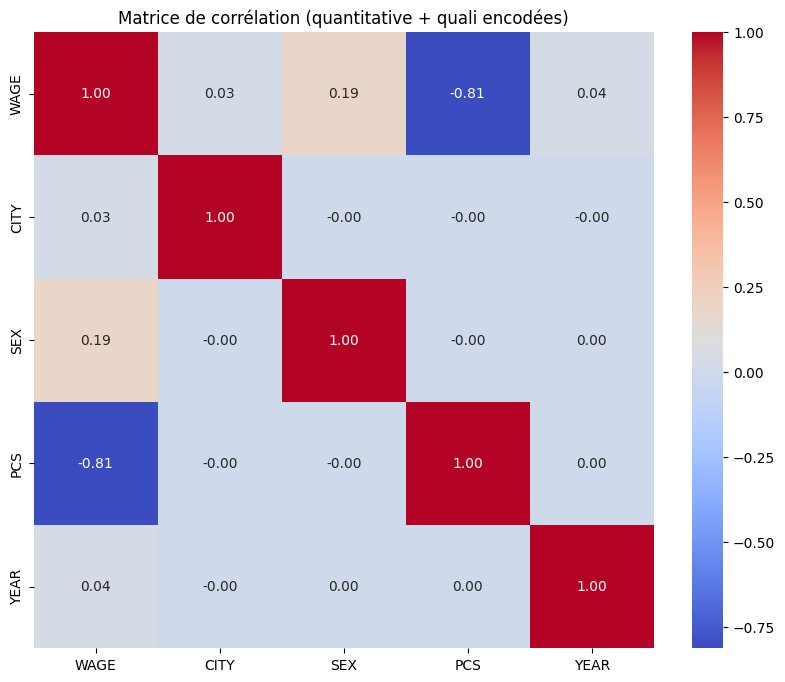


Tableau de contingence : CITY x SEX
SEX    F  M
CITY       
001    8  8
00152  8  8
00154  8  8
00156  8  8
00158  8  8
...   .. ..
GEN    8  8
LAU    8  8
LUX    8  8
MON    8  8
SAR    8  8

[9563 rows x 2 columns]

Tableau de contingence : CITY x PCS
PCS    3  4  5  6
CITY             
001    4  4  4  4
00152  4  4  4  4
00154  4  4  4  4
00156  4  4  4  4
00158  4  4  4  4
...   .. .. .. ..
GEN    4  4  4  4
LAU    4  4  4  4
LUX    4  4  4  4
MON    4  4  4  4
SAR    4  4  4  4

[9563 rows x 4 columns]

Tableau de contingence : CITY x YEAR
YEAR   2022  2023
CITY             
001       8     8
00152     8     8
00154     8     8
00156     8     8
00158     8     8
...     ...   ...
GEN       8     8
LAU       8     8
LUX       8     8
MON       8     8
SAR       8     8

[9563 rows x 2 columns]

Tableau de contingence : SEX x PCS
PCS      3      4      5      6
SEX                            
F    23350  23350  23350  23350
M    23350  23350  23350  23350

Tableau de contingence :

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#Variables quali vs quanti
quant_cols = ['WAGE']  # seules les variables numériques réelles
quali_cols = ['CITY','SEX', 'PCS', 'YEAR']

#Encoder les variables qualitatives pour corr
df_encoded = data.copy()
label_encoders = {}
for col in quali_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

cols_to_corr = quant_cols + quali_cols  # WAGE + CITY_CODE, SEX, PCS, YEAR
df_corr = df_encoded[cols_to_corr]

# Matrice de corrélation
corr_matrix = df_corr.corr(numeric_only=True)

# HEATMAP
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation (quantitative + quali encodées)")
plt.show()

# Tableau de contingence
for i in range(len(quali_cols)):
    for j in range(i+1, len(quali_cols)):
        col1 = quali_cols[i]
        col2 = quali_cols[j]
        print(f"\nTableau de contingence : {col1} x {col2}")
        print(pd.crosstab(data[col1], data[col2]))

In [ ]:
print(df_encoded.dtypes)

CITY             object
INSEE ZONING     object
SEX               int64
PCS               int64
YEAR              int64
WAGE            float64
CITY_CODE         int64
dtype: object


In [ ]:
#Partie Machine Learning
#Variable cible = WAGE
#Features = Ne pas prendre la ville car corrélé à l'insee zoning et + précis

#Importer les librairies ML

import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
df = data.copy() #Dataframe dédié
y = df["WAGE"] # variable target

In [46]:
#On encode les variables quali avec One Hot Encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#Features qualitatives
cat_features = ['SEX', 'PCS', 'YEAR', 'CITY']

# OneHotEncoder + transformation automatique
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

# Transformer les features
X_encoded = encoder.fit_transform(data[cat_features])

In [47]:
#On divise en ensemble train et test
X = df_encoded[quali_cols]  # tes features encodées
y = df_encoded['WAGE']       # ta cible
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42) #On utilise bien le X_encoded pour avoir nos variables transformées

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.metrics import r2_score

# RMSE (manuellement si squared=False non disponible)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE :", rmse)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE :", mae)

r2 = r2_score(y_test, y_pred)
print("R² :", r2)


RMSE : 297.6223189967736
MAE : 198.32019897459492
R² : 0.8711372847736902


In [ ]:
#Les prédictions ont un écart de 343€ en moyenne par rapport au salaire réel
#R2 = le modèle explique 87% de la variance des salaires :  la majorité des différences observées sont liées aux variables que l'on a définies

Test du modèle Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Initialiser le modèle
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraînement
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42) #On utilise bien le X_encoded pour avoir nos variables transformées

rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)

# Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² :", r2)
